# Custom CNN for Driver Distraction Detection (Advanced Architecture)

This notebook implements an enhanced Convolutional Neural Network (CNN) for driver distraction classification using the filtered 3-class dataset.

Improvements over the baseline:
- Deeper architecture with more convolutional layers
- Use of Batch Normalization and DropBlock (if implemented)
- Regularization via L2 penalty
- Potential use of residual connections and attention (optional)

Goals:
- Improve classification performance compared to the baseline
- Handle class imbalance and generalize better on unseen data


### 1. Import Required Libraries
We import TensorFlow, Keras layers, optimizers, and evaluation metrics, along with any custom components like DropBlock and residual connections if used.


In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Set global seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


### 2. Set Hyperparameters and Paths
We define key hyperparameters such as image size, batch size, number of classes, paths to data directories and metadata CSV files.


In [2]:
# Paths
train_csv = '../split_data/training_data.csv'
val_csv = '../split_data/validation_data.csv'
test_csv = '../split_data/testing_data.csv'

train_dir = '../split_data/training'
val_dir = '../split_data/validation'
test_dir = '../split_data/testing'

# Load CSVs
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Define class label order
target_classes = ['safe_driving', 'using_phone', 'drinking']


### 3. Define Data Generators
We prepare `ImageDataGenerator` instances for training (with augmentation) and for validation/testing (with rescaling only).


In [3]:


# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Base directory and CSVs
base_dir = "../split_data"

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)


target_classes = ['safe_driving', 'using_phone', 'drinking']
# Validation and test: only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "training_data.csv")),
    directory=os.path.join(base_dir, "training"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED,
    classes=target_classes
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "validation_data.csv")),
    directory=os.path.join(base_dir, "validation"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=target_classes
)

# Testing generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "testing_data.csv")),
    directory=os.path.join(base_dir, "testing"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=target_classes
)


Found 8442 validated image filenames belonging to 3 classes.
Found 2814 validated image filenames belonging to 3 classes.
Found 2814 validated image filenames belonging to 3 classes.


### 4. Load Image Data via DataFrame
We load the training, validation, and test datasets using `flow_from_dataframe` to generate batches of images and labels from CSV metadata.
We also compute balanced class weights

In [4]:


# Define the correct mapping
label_map = {
    'safe_driving': 0,
    'using_phone': 1,
    'drinking': 2
}

# Load the training labels and map them correctly
df_train = pd.read_csv(os.path.join(base_dir, "training_data.csv"))
y_train_str = df_train["class_id"]
y_train = y_train_str.map(label_map)  # Convert string to int labels: 0/1/2

# Check if any NaNs occurred due to unmapped labels
if y_train.isnull().any():
    print("Unmapped labels found in y_train!")
    print(y_train_str[ y_train.isnull() ].unique())

# Now compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=y_train
)

# Convert to dict for Keras
class_weights = dict(zip([0, 1, 2], class_weights))
print("Corrected class weights:", class_weights)


Corrected class weights: {0: 1.884795713328868, 1: 0.5066618653222903, 2: 2.0172043010752687}


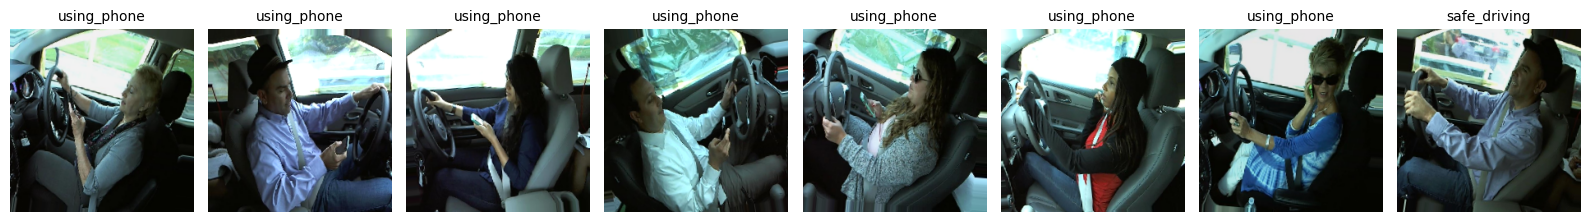

In [5]:


# Getting one batch of augmented images and labels
images, labels = next(train_generator)

# Plot the first 8 images from the batch
plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


### 5. Define Custom CNN Architecture
We build a deeper CNN with advanced features like Batch Normalization, L2 regularization, and optionally DropBlock or residual connections.
We compile the model using Adam optimizer and categorical crossentropy loss. We also track accuracy, precision, and recall during training.

In [6]:
# Stabilized custom CNN
custom_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # NEW intermediate softer layer
    Conv2D(96, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Global feature pooling
    GlobalAveragePooling2D(),

    # Dense + Regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.4),   # slightly increased

    # Output
    Dense(3, activation='softmax')
])

# Compile
custom_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("custom_cnn_model", monitor='val_accuracy', save_best_only=True, save_format='tf')
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,    # cut LR in half when val_loss stalls
    patience=2,    # wait 2 bad epochs before reducing LR
    verbose=1,
    min_lr=1e-6
)


custom_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        


### 6. Train the Custom CNN Model
We fit the model on the training data using class weights to balance underrepresented classes, and validate it on the validation set.


In [7]:
history = custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    class_weight=class_weights
)
custom_model.save("custom_cnn_model", save_format='tf')



Epoch 1/25
264/264 [==============================] - ETA: 0s - loss: 1.1556 - accuracy: 0.4768

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 275s 1s/step - loss: 1.1556 - accuracy: 0.4768 - val_loss: 1.1960 - val_accuracy: 0.3962 - lr: 5.0000e-04
Epoch 2/25
264/264 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.6896

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 262s 990ms/step - loss: 0.7425 - accuracy: 0.6896 - val_loss: 1.0152 - val_accuracy: 0.5988 - lr: 5.0000e-04
Epoch 3/25
264/264 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.8240

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 309s 1s/step - loss: 0.5093 - accuracy: 0.8240 - val_loss: 0.6082 - val_accuracy: 0.7982 - lr: 5.0000e-04
Epoch 4/25
264/264 [==============================] - 259s 981ms/step - loss: 0.3662 - accuracy: 0.8928 - val_loss: 3.5432 - val_accuracy: 0.2811 - lr: 5.0000e-04
Epoch 5/25
264/264 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9215

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 269s 1s/step - loss: 0.2965 - accuracy: 0.9215 - val_loss: 0.4195 - val_accuracy: 0.8984 - lr: 5.0000e-04
Epoch 6/25
264/264 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9443

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 365s 1s/step - loss: 0.2394 - accuracy: 0.9443 - val_loss: 0.3620 - val_accuracy: 0.9126 - lr: 5.0000e-04
Epoch 7/25
264/264 [==============================] - 257s 973ms/step - loss: 0.1933 - accuracy: 0.9569 - val_loss: 1.9581 - val_accuracy: 0.4733 - lr: 5.0000e-04
Epoch 8/25
264/264 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9626
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
264/264 [==============================] - 259s 979ms/step - loss: 0.1755 - accuracy: 0.9626 - val_loss: 0.4163 - val_accuracy: 0.8618 - lr: 5.0000e-04
Epoch 9/25
264/264 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9796

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 261s 988ms/step - loss: 0.1278 - accuracy: 0.9796 - val_loss: 0.1426 - val_accuracy: 0.9712 - lr: 2.5000e-04
Epoch 10/25
264/264 [==============================] - 417s 2s/step - loss: 0.1154 - accuracy: 0.9822 - val_loss: 0.3870 - val_accuracy: 0.8859 - lr: 2.5000e-04
Epoch 11/25
264/264 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9845
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
264/264 [==============================] - 417s 2s/step - loss: 0.1044 - accuracy: 0.9845 - val_loss: 0.9283 - val_accuracy: 0.6720 - lr: 2.5000e-04
Epoch 12/25
264/264 [==============================] - 395s 1s/step - loss: 0.0930 - accuracy: 0.9890 - val_loss: 0.1781 - val_accuracy: 0.9527 - lr: 1.2500e-04
Epoch 13/25
264/264 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9906

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 392s 1s/step - loss: 0.0844 - accuracy: 0.9906 - val_loss: 0.1260 - val_accuracy: 0.9730 - lr: 1.2500e-04
Epoch 14/25
264/264 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9898

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 316s 1s/step - loss: 0.0859 - accuracy: 0.9898 - val_loss: 0.0831 - val_accuracy: 0.9908 - lr: 1.2500e-04
Epoch 15/25
264/264 [==============================] - 405s 2s/step - loss: 0.0773 - accuracy: 0.9927 - val_loss: 0.1187 - val_accuracy: 0.9751 - lr: 1.2500e-04
Epoch 16/25
264/264 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9932
Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
264/264 [==============================] - 411s 2s/step - loss: 0.0710 - accuracy: 0.9932 - val_loss: 0.0930 - val_accuracy: 0.9844 - lr: 1.2500e-04
Epoch 17/25
264/264 [==============================] - 399s 2s/step - loss: 0.0651 - accuracy: 0.9938 - val_loss: 0.0725 - val_accuracy: 0.9908 - lr: 6.2500e-05
Epoch 18/25
264/264 [==============================] - 386s 1s/step - loss: 0.0638 - accuracy: 0.9947 - val_loss: 0.0779 - val_accuracy: 0.9897 - lr: 6.2500e-05
Epoch 19/25
264/264 [=========================

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 351s 1s/step - loss: 0.0551 - accuracy: 0.9960 - val_loss: 0.0661 - val_accuracy: 0.9915 - lr: 1.5625e-05
Epoch 25/25
264/264 [==============================] - 299s 1s/step - loss: 0.0544 - accuracy: 0.9963 - val_loss: 0.0677 - val_accuracy: 0.9911 - lr: 1.5625e-05


INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


### 7. Evaluate Custom CNN on Test Data
We evaluate the final model on the unseen test dataset and print the performance metrics to assess generalization.
We generate predictions on test data and output a classification report and confusion matrix to analyze class-wise model performance.


88/88 [==============================] - 26s 296ms/step


<Figure size 600x600 with 0 Axes>

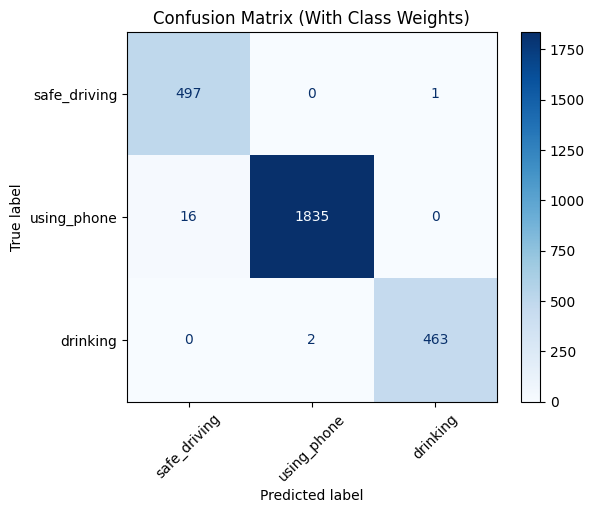

Classification Report (With Class Weights):
              precision    recall  f1-score   support

safe_driving       0.97      1.00      0.98       498
 using_phone       1.00      0.99      1.00      1851
    drinking       1.00      1.00      1.00       465

    accuracy                           0.99      2814
   macro avg       0.99      1.00      0.99      2814
weighted avg       0.99      0.99      0.99      2814



In [8]:


# Predicting on test data
y_pred_probs = custom_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True labels
y_true_classes = test_generator.classes

# Class label mapping
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (With Class Weights)")
plt.show()

# Classification Report
print("Classification Report (With Class Weights):")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


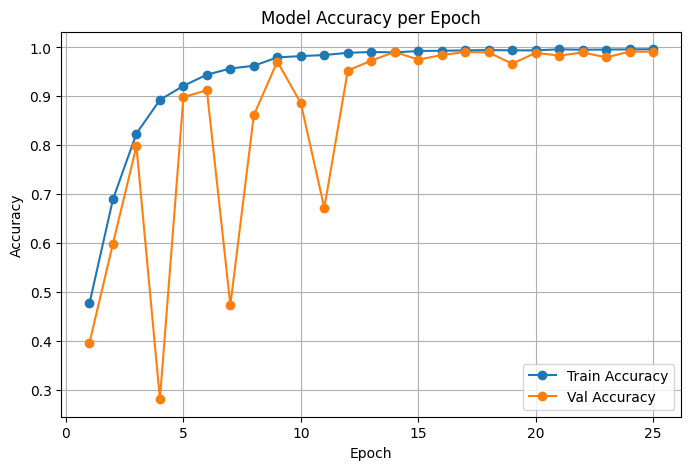

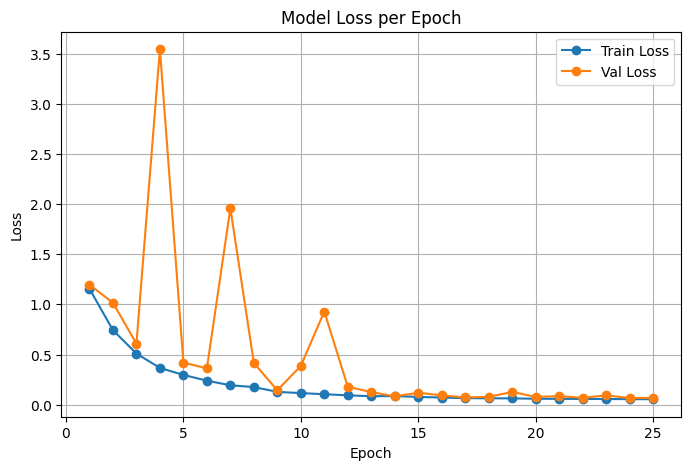

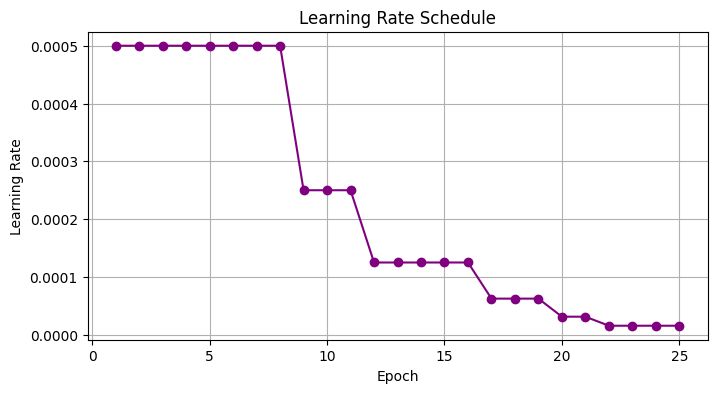

In [9]:
# Extract learning rate history 
if 'lr' in history.history:
    lrs = history.history['lr'] 
else:
    lrs = history.history['learning_rate']  

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, lrs, color='purple', marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


88/88 [==============================] - 18s 204ms/step


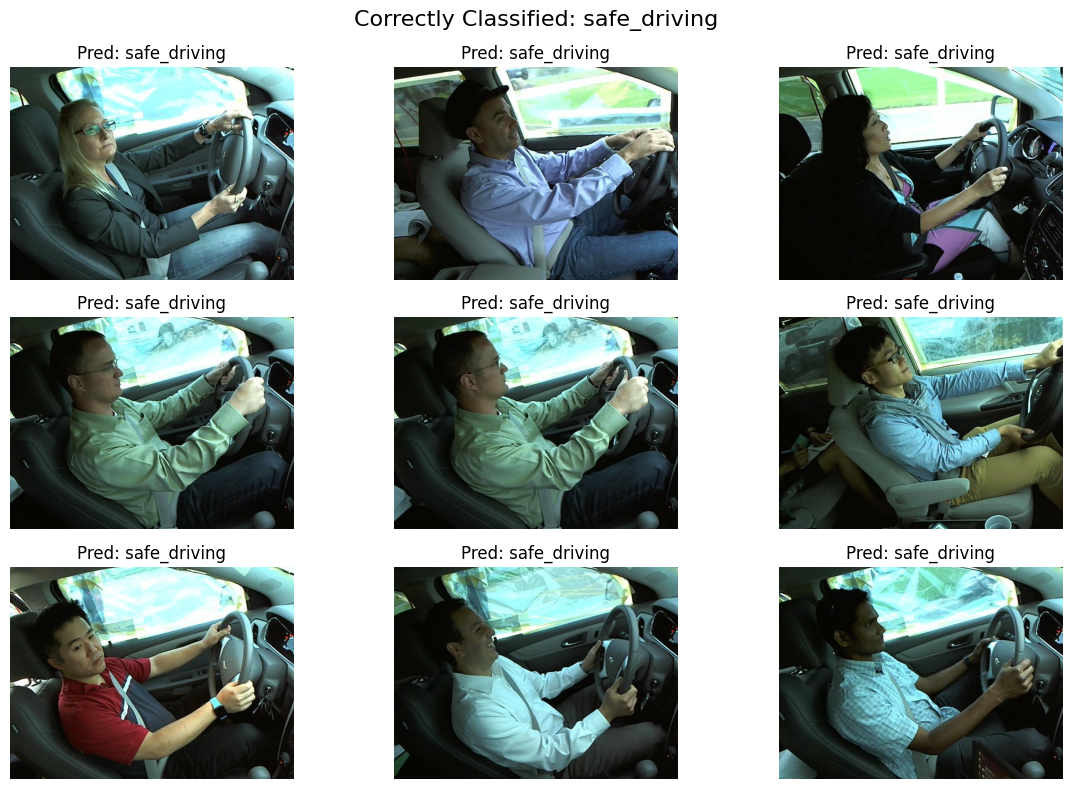

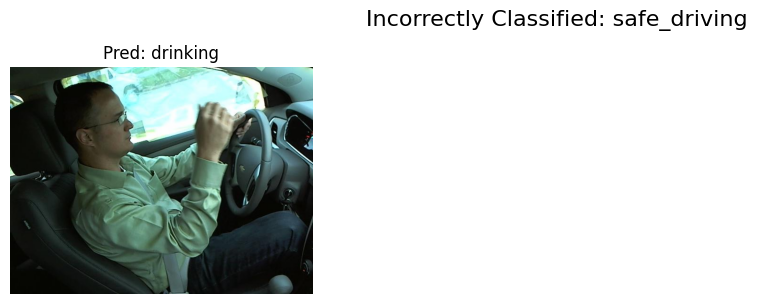

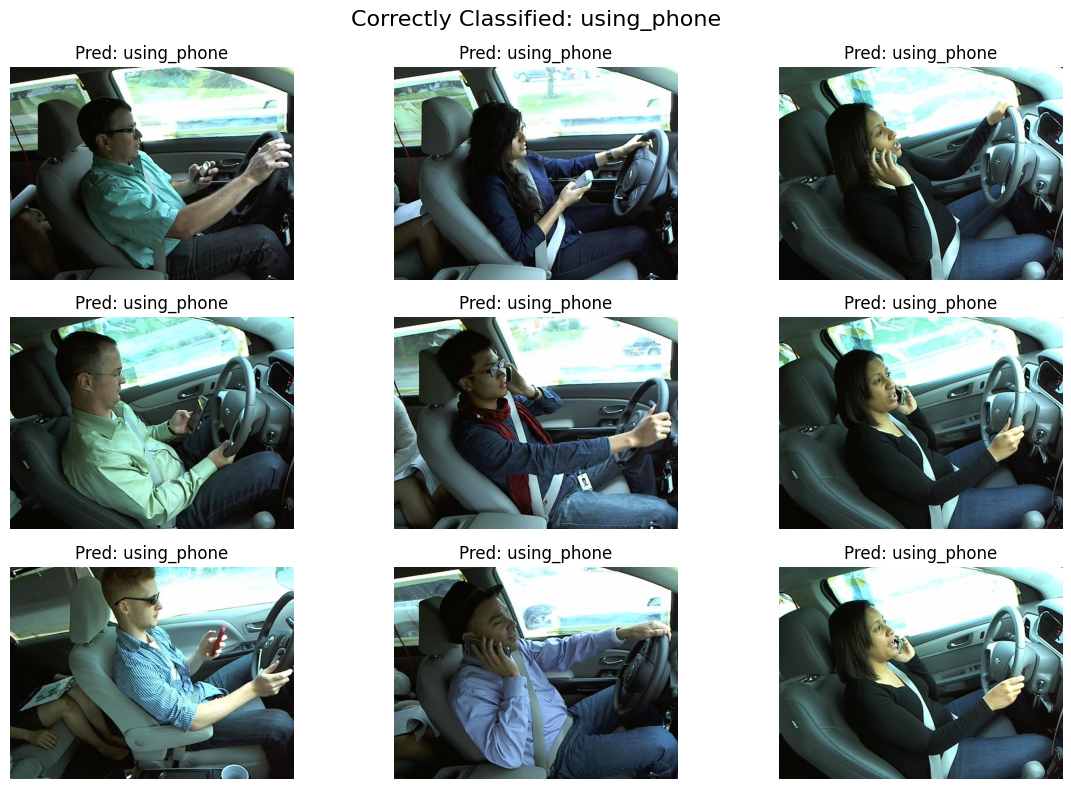

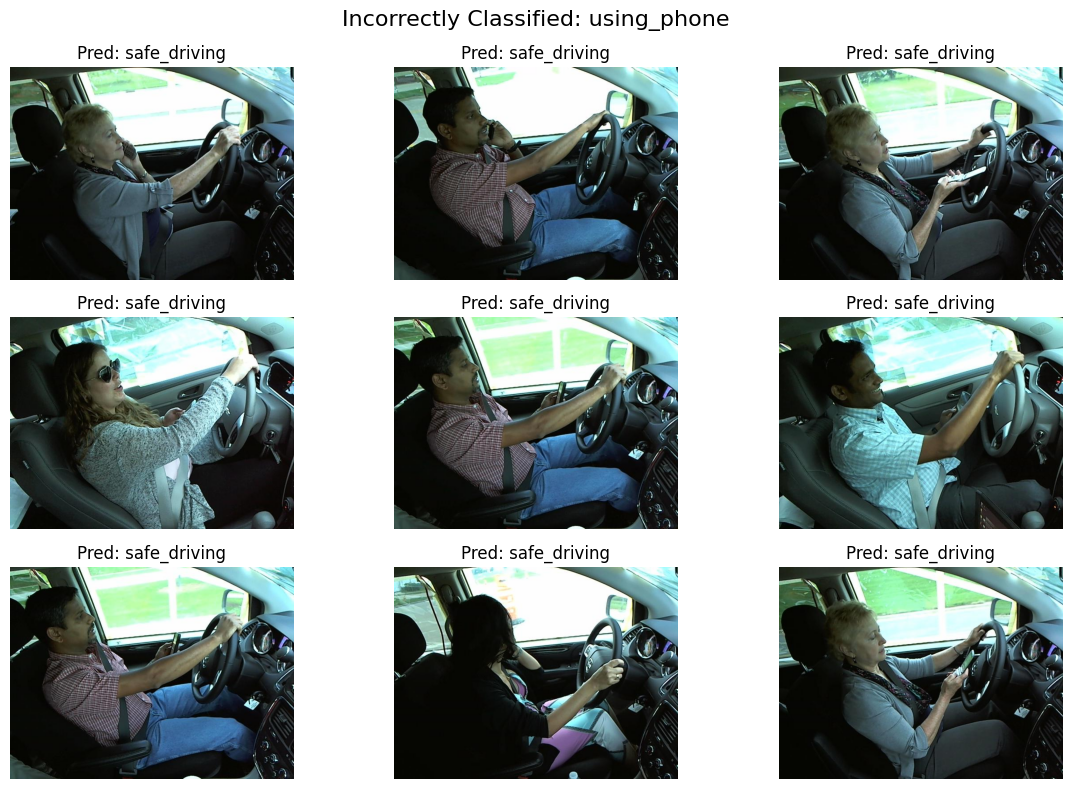

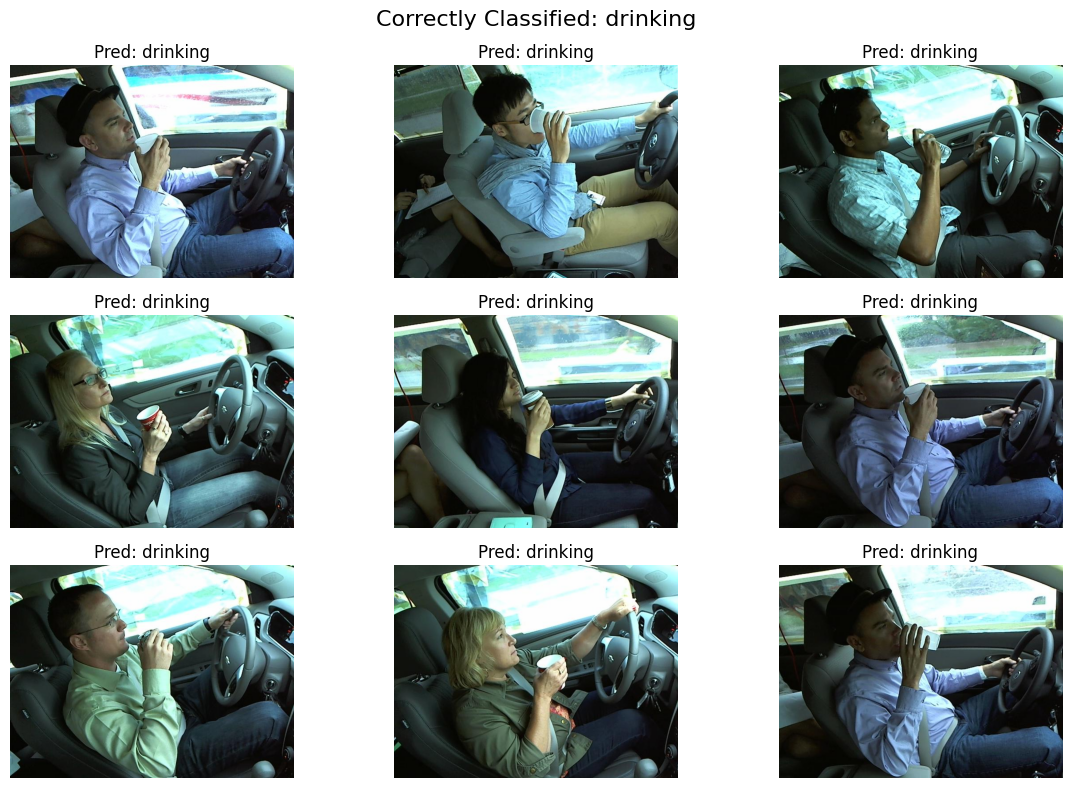

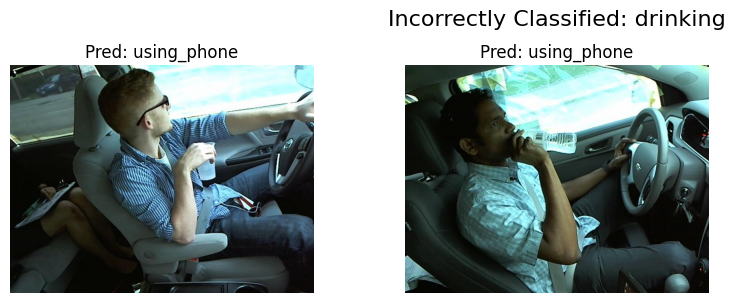

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Reload model
model = tf.keras.models.load_model("custom_cnn_model")


# Predictions on test set
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
filepaths = test_generator.filepaths

# Class name mapping
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
test_dir = "../split_data/testing"

# Plotting function
def plot_predictions_by_class(class_name, correct=True, max_images=9):
    class_idx = class_indices[class_name]
    indices = np.where(np.array(y_true).flatten() == class_idx)[0]
    if correct:
        selected = [i for i in indices if y_pred[i] == y_true[i]]
        title = f"Correctly Classified: {class_name}"
    else:
        selected = [i for i in indices if y_pred[i] != y_true[i]]
        title = f"Incorrectly Classified: {class_name}"

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(selected[:max_images]):
        img_path = os.path.join(test_dir, os.path.basename(filepaths[idx]))
        img = plt.imread(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {idx_to_class[y_pred[idx]]}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Run for all 3 classes
for cls in ['safe_driving', 'using_phone', 'drinking']:
    plot_predictions_by_class(cls, correct=True)
    plot_predictions_by_class(cls, correct=False)


In [11]:
import os

model_path = "custom_cnn_model.keras"
print("Is it a file?", os.path.isfile(model_path))
print("Is it a directory?", os.path.isdir(model_path))


Is it a file? True
Is it a directory? False


In [13]:
from tensorflow.keras.utils import plot_model
plot_model(custom_model, to_file="cnn_architecture.png", show_shapes=True, show_layer_names=True)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
